# 1.0 Import Data

In [30]:
import pandas as pd
import nltk
import seaborn as sns #Kenneth
import matplotlib.pyplot as plt
import string
import demoji
import contractions
import time
import re

from langdetect import detect,detect_langs #pip install langdetect (Kenneth)
from wordcloud import WordCloud, ImageColorGenerator
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.pipeline import Pipeline
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

import warnings
warnings.filterwarnings("ignore")
#nltk.download('wordnet')
#nltk.download('omw-1.4')
#nltk.download('punkt')



In [2]:
# https://shopee.com.my/-READY-STOCK-BAJU-MELAYU-SLIM-FIT-DEWASA-DAN-BUDAK-(kain-sating)-RAYA-2024-i.310588344.24263963059?sp_atk=287c391c-faaa-41a1-82f2-7256758aae1e&xptdk=287c391c-faaa-41a1-82f2-7256758aae1e
# https://shopee.com.my/SALE-!!!!Baju-Melayu-Slimfit-dan-Regular-Warna-Cream-i.45909008.4503941744?sp_atk=8aaff726-92bd-4a36-a751-26b59408ed33&xptdk=8aaff726-92bd-4a36-a751-26b59408ed33


# Define file paths
data1  = "dataset1.csv"
data2 = "dataset2.csv"

# Read CSV files into DataFrames
df1 = pd.read_csv(data1)
df2 = pd.read_csv(data2, encoding='latin1')

data = pd.concat([df1, df2], ignore_index=True)

data.to_csv("merged_data.csv", index=False)

In [3]:
# Data Overview

In [4]:
data.describe()

,No.,Rating
count,466.000000,466.000000
mean,217.532189,3.343348
std,133.931229,1.471642
min,1.000000,1.000000
25%,101.250000,2.000000
50%,217.500000,3.000000
75%,333.750000,5.000000
max,450.000000,5.000000


In [5]:
data.head()

,No.,Author,Rating,Review
0,1,n*****n,3,"baju kurta sampai dalam keadaan baik, tapi tak..."
1,2,y*****i,2,"Sizing tak accurate langsung, aku rasa macam b..."
2,3,amalinadinee,2,"Baju kurta aku dah koyak sebelum pakai, memang..."
3,4,c*****8,5,Delivery laju. Kain cantik. Thanks seller. Mas...
4,5,8kbvdmoyw9,5,Baju selamat mendarat kain cantik dan sedap di...


In [6]:
data.tail()

,No.,Author,Rating,Review
461,12,m*****4,1,Warna nude kita mintak warna lain yg Smpai lpa...
462,13,khaynurul,5,NaN
463,14,k_w1z356vg,5,tidak mengikuti saiz yg saya nak
464,15,acikmaira,1,Ukuran tak sama saiz besar
465,16,fvxmwlvyq7,5,NaN


In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 466 entries, 0 to 465
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   No.     466 non-null    int64 
 1   Author  466 non-null    object
 2   Rating  466 non-null    int64 
 3   Review  462 non-null    object
dtypes: int64(2), object(2)
memory usage: 14.7+ KB


# 2.0 Data Preprocessing

In [11]:
# Column Transformation

In [12]:
data.columns

Index(['No.', 'Author', 'Rating', 'Review'], dtype='object')

In [14]:
data.columns=['No.', 'Author', 'Product Rating', 'Product Review']

In [15]:
data.head()

,No.,Author,Product Rating,Product Review
0,1,n*****n,3,"baju kurta sampai dalam keadaan baik, tapi tak..."
1,2,y*****i,2,"Sizing tak accurate langsung, aku rasa macam b..."
2,3,amalinadinee,2,"Baju kurta aku dah koyak sebelum pakai, memang..."
3,4,c*****8,5,Delivery laju. Kain cantik. Thanks seller. Mas...
4,5,8kbvdmoyw9,5,Baju selamat mendarat kain cantik dan sedap di...


### 2.1 Data Cleaning and Formatting

In [16]:
data.isnull().any().any()

True

In [17]:
data.isna().any()

No.               False
Author            False
Product Rating    False
Product Review     True
dtype: bool

In [18]:
data=data.dropna(subset=['Product Review'])

In [19]:
data.to_csv('clean_dataset.csv', index=False)

In [20]:
data.isnull().any().any()

False

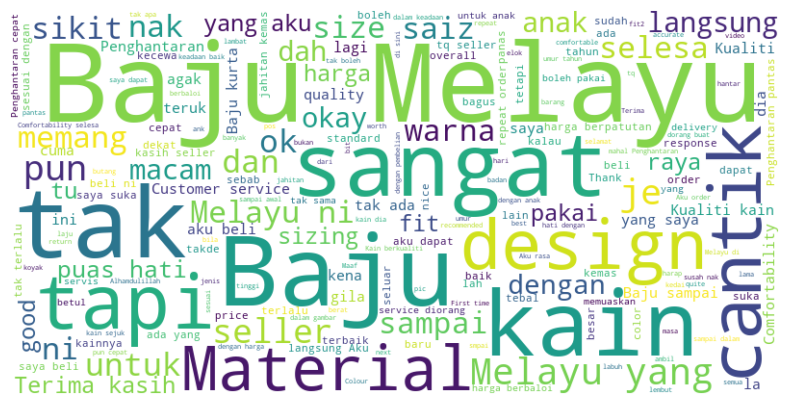

In [22]:
# Generate the word cloud
def clean_review(review):
  if not isinstance(review, str):
    return str(review)  # Convert float to string
  else:
    return review

cleaned_reviews = [clean_review(review) for review in data['Product Review']]
reviews_text = ' '.join(cleaned_reviews)

wordcloud = WordCloud(width=800, height=400, max_words=200, background_color='white').generate(reviews_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [ ]:
# EDA

In [24]:
# Create a new DataFrame with only the desired columns
selected_columns = ['Product Rating', 'Product Review']
data = data[selected_columns]

# Display the new DataFrame
data

,Product Rating,Product Review
0,3,"baju kurta sampai dalam keadaan baik, tapi tak..."
1,2,"Sizing tak accurate langsung, aku rasa macam b..."
2,2,"Baju kurta aku dah koyak sebelum pakai, memang..."
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...
4,5,Baju selamat mendarat kain cantik dan sedap di...
...,...,...
458,3,Pada baju ada warna merah\nCuba basuh masih x ...
460,2,Colour a bit different from the picture. And m...
461,1,Warna nude kita mintak warna lain yg Smpai lpa...
463,5,tidak mengikuti saiz yg saya nak


In [27]:
# case folding and lowercasing
def casefolding(Review):
    Review = Review.lower()
    return Review
data['LowerCaseReview'] = data['Product Review'].apply(casefolding)
data.head()

,Product Rating,Product Review,LowerCaseReview
0,3,"baju kurta sampai dalam keadaan baik, tapi tak...","baju kurta sampai dalam keadaan baik, tapi tak..."
1,2,"Sizing tak accurate langsung, aku rasa macam b...","sizing tak accurate langsung, aku rasa macam b..."
2,2,"Baju kurta aku dah koyak sebelum pakai, memang...","baju kurta aku dah koyak sebelum pakai, memang..."
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...,delivery laju. kain cantik. thanks seller. mas...
4,5,Baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...


In [28]:
import string

# Define the set of punctuation characters
remove = set(string.punctuation)

# Function to remove punctuation
def remove_punctuation(text):
    return ' '.join(word.strip(''.join(remove)) for word in text.split())

# Apply the function to the 'Review_Lcase' column
data['RemovedPuncReview'] = data['LowerCaseReview'].apply(remove_punctuation)

# Display the updated DataFrame
data.head()

,Product Rating,Product Review,LowerCaseReview,RemovedPuncReview
0,3,"baju kurta sampai dalam keadaan baik, tapi tak...","baju kurta sampai dalam keadaan baik, tapi tak...",baju kurta sampai dalam keadaan baik tapi tak ...
1,2,"Sizing tak accurate langsung, aku rasa macam b...","sizing tak accurate langsung, aku rasa macam b...",sizing tak accurate langsung aku rasa macam ba...
2,2,"Baju kurta aku dah koyak sebelum pakai, memang...","baju kurta aku dah koyak sebelum pakai, memang...",baju kurta aku dah koyak sebelum pakai memang ...
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...,delivery laju. kain cantik. thanks seller. mas...,delivery laju kain cantik thanks seller masih ...
4,5,Baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...


In [31]:
# Define a function to remove special characters
def remove_special_characters(text):
    # Using regular expression to keep only alphanumeric characters and spaces
    return re.sub(r'[^a-zA-Z0-9\s]', '', text)

# Apply the function to the 'Review_Lcase' column
data['RemovedSpecialCharReview'] = data['RemovedPuncReview'].apply(remove_special_characters)

# Display the first few rows
data.head()

,Product Rating,Product Review,LowerCaseReview,RemovedPuncReview,RemovedSpecialCharReview
0,3,"baju kurta sampai dalam keadaan baik, tapi tak...","baju kurta sampai dalam keadaan baik, tapi tak...",baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...
1,2,"Sizing tak accurate langsung, aku rasa macam b...","sizing tak accurate langsung, aku rasa macam b...",sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...
2,2,"Baju kurta aku dah koyak sebelum pakai, memang...","baju kurta aku dah koyak sebelum pakai, memang...",baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...,delivery laju. kain cantik. thanks seller. mas...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...
4,5,Baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...


In [32]:
#!pip install demoji

In [33]:
import demoji

# Convert 'Review_Cleaned' column to strings
data['RemovedSpecialCharReview'] = data['RemovedSpecialCharReview'].astype(str)

# Remove emojis from the 'Review_Cleaned' column
data['DemojiReview'] = data['RemovedSpecialCharReview'].apply(lambda x: demoji.replace(x, ''))

# Display the updated DataFrame
data.head()


,Product Rating,Product Review,LowerCaseReview,RemovedPuncReview,RemovedSpecialCharReview,DemojiReview
0,3,"baju kurta sampai dalam keadaan baik, tapi tak...","baju kurta sampai dalam keadaan baik, tapi tak...",baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...
1,2,"Sizing tak accurate langsung, aku rasa macam b...","sizing tak accurate langsung, aku rasa macam b...",sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...
2,2,"Baju kurta aku dah koyak sebelum pakai, memang...","baju kurta aku dah koyak sebelum pakai, memang...",baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...,delivery laju. kain cantik. thanks seller. mas...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...
4,5,Baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...


In [34]:
#!pip install contractions

In [167]:
import contractions

contractions.add('x','tidak')
contractions.add('tak','tidak')

# Function to expand contractions
def expand_contractions(text):
    return contractions.fix(text)

# Apply the function to the 'Review_Lcase' column
data['ContractionReview'] = data['DemojiReview'].apply(expand_contractions)

# Display the updated DataFrame
data.head()

KeyError: 'DemojiReview'

In [39]:
# Function to remove single characters except 'x'
def remove_single_characters_except_x(text):
    return re.sub(r'\b[^x\s]\b', '', text)

# Apply the function to the 'Review_Lcase' column
data['RemovedSingleCharReview'] = data['ContractionReview'].apply(remove_single_characters_except_x)

# Display the updated DataFrame
data.head()

,Product Rating,Product Review,LowerCaseReview,RemovedPuncReview,RemovedSpecialCharReview,DemojiReview,ContractionReview,RemovedSingleCharReview
0,3,"baju kurta sampai dalam keadaan baik, tapi tak...","baju kurta sampai dalam keadaan baik, tapi tak...",baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...
1,2,"Sizing tak accurate langsung, aku rasa macam b...","sizing tak accurate langsung, aku rasa macam b...",sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...
2,2,"Baju kurta aku dah koyak sebelum pakai, memang...","baju kurta aku dah koyak sebelum pakai, memang...",baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...,delivery laju. kain cantik. thanks seller. mas...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...
4,5,Baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...


### 2.2 Data Translation

In [40]:
# !pip install translate
# !pip install --upgrade googletrans==4.0.0-rc1
# !pip install translators -- upgrade


In [41]:
from googletrans import Translator
import pandas as pd
import time

translator = Translator()

# Function to translate a single review with a delay
def translate_review(review):
    try:
        translation = translator.translate(review, src='en', dest='ms')
        time.sleep(1)  # Introduce a 1-second delay to avoid potential issues
        return translation.text
    except Exception as e:
        print(f"Error during translation: {e}")
        return review

# Assuming 'data' is your original DataFrame with a column 'Cleaned_Review'
data['Translated_Review_MS'] = data['RemovedSingleCharReview'].apply(translate_review)

# Display the DataFrame with both original and translated reviews
print(data[['RemovedSingleCharReview', 'Translated_Review_MS']])


                               RemovedSingleCharReview  \
0    baju kurta sampai dalam keadaan baik tapi tak ...   
1    sizing tak accurate langsung aku rasa macam ba...   
2    baju kurta aku dah koyak sebelum pakai memang ...   
3    delivery laju kain cantik thanks seller masih ...   
4    baju selamat mendarat kain cantik dan sedap di...   
..                                                 ...   
458  pada baju ada warna merah cuba basuh masih x h...   
460  colour  bit different from the picture and mod...   
461  warna nude kita mintak warna lain yg smpai lpa...   
463                   tidak mengikuti saiz yg saya nak   
464                         ukuran tak sama saiz besar   

                                  Translated_Review_MS  
0    Baju kurta Sampai Dalam Keadaan Baik Tapi Tak ...  
1    SIZING TAK Tepat Langsung Aku Rasa Macam Baju ...  
2    Baju kurta aku dah koyakkum pakai memang tak k...  
3    Penghantaran Laju Kain Cantik Terima kasih Pen...  
4    Baju Selamat 

In [69]:
translated_review_MS = data ['Translated_Review_MS']

translated_review_MS.to_csv('Translated_Review_MS.csv', index=False)


In [70]:
translated_review_MS.head()

0    baju kurta sampai dalam ada baik tapi tak ada ...
1    sizing tak tepat langsung aku rasa macam baju ...
2    baju kurta saya dah koyakkum pakai memang tak ...
3    hantar laju kain cantik terima kasih jual masi...
4    baju selamat darat kain cantik dan sedap di pa...
Name: Translated_Review_MS, dtype: object

### 2.3 Tokenization

In [71]:
# tokenization

from nltk.tokenize import word_tokenize
#NLTK word tokenize
def word_tokenize_wrapper(text):
 return word_tokenize(text)
data['Translated_Review_MS'] = data['Translated_Review_MS'].apply(word_tokenize_wrapper)
data.head()

,Product Rating,Product Review,LowerCaseReview,RemovedPuncReview,RemovedSpecialCharReview,DemojiReview,ContractionReview,RemovedSingleCharReview,Translated_Review_MS,POS_Tags,Sentiment_MS
0,3,"baju kurta sampai dalam keadaan baik, tapi tak...","baju kurta sampai dalam keadaan baik, tapi tak...",baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,"[baju, kurta, sampai, dalam, ada, baik, tapi, ...","[(Baju, NNP), (kurta, VBD), (Sampai, NNP), (Da...",Neutral
1,2,"Sizing tak accurate langsung, aku rasa macam b...","sizing tak accurate langsung, aku rasa macam b...",sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,"[sizing, tak, tepat, langsung, aku, rasa, maca...","[(SIZING, NN), (TAK, NNP), (Tepat, NNP), (Lang...",Negative
2,2,"Baju kurta aku dah koyak sebelum pakai, memang...","baju kurta aku dah koyak sebelum pakai, memang...",baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,"[baju, kurta, saya, dah, koyakkum, pakai, mema...","[(Baju, NNP), (kurta, VBD), (saya, JJ), (dah, ...",Negative
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...,delivery laju. kain cantik. thanks seller. mas...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,"[hantar, laju, kain, cantik, terima, kasih, ju...","[(Penghantaran, NNP), (Laju, NNP), (Kain, NNP)...",Positive
4,5,Baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,"[baju, selamat, darat, kain, cantik, dan, seda...","[(Baju, NNP), (Selamat, NNP), (Mendarat, NNP),...",Positive


### 2.4 Normalization

In [72]:
# normalization

normalized_word = pd.read_csv("normalisasi.csv")
normalized_word_dict = {}

for index, row in normalized_word.iterrows():
    if row[0] not in normalized_word_dict:
        normalized_word_dict[row[0]] = row[1] 

def normalized_term(document):
    return [normalized_word_dict[term] if term in normalized_word_dict else term for term in document]

data['Translated_Review_MS'] = data['Translated_Review_MS'].apply(normalized_term)
data.head()

,Product Rating,Product Review,LowerCaseReview,RemovedPuncReview,RemovedSpecialCharReview,DemojiReview,ContractionReview,RemovedSingleCharReview,Translated_Review_MS,POS_Tags,Sentiment_MS
0,3,"baju kurta sampai dalam keadaan baik, tapi tak...","baju kurta sampai dalam keadaan baik, tapi tak...",baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,baju kurta sampai dalam keadaan baik tapi tak ...,"[baju, kurta, sampai, dalam, ada, baik, tetapi...","[(Baju, NNP), (kurta, VBD), (Sampai, NNP), (Da...",Neutral
1,2,"Sizing tak accurate langsung, aku rasa macam b...","sizing tak accurate langsung, aku rasa macam b...",sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,sizing tak accurate langsung aku rasa macam ba...,"[sizing, tak, tepat, langsung, saya, rasa, mac...","[(SIZING, NN), (TAK, NNP), (Tepat, NNP), (Lang...",Negative
2,2,"Baju kurta aku dah koyak sebelum pakai, memang...","baju kurta aku dah koyak sebelum pakai, memang...",baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,baju kurta aku dah koyak sebelum pakai memang ...,"[baju, kurta, saya, dah, koyakkum, pakai, mema...","[(Baju, NNP), (kurta, VBD), (saya, JJ), (dah, ...",Negative
3,5,Delivery laju. Kain cantik. Thanks seller. Mas...,delivery laju. kain cantik. thanks seller. mas...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,delivery laju kain cantik thanks seller masih ...,"[hantar, laju, kain, cantik, terima, kasih, ju...","[(Penghantaran, NNP), (Laju, NNP), (Kain, NNP)...",Positive
4,5,Baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,baju selamat mendarat kain cantik dan sedap di...,"[baju, selamat, darat, kain, cantik, dan, seda...","[(Baju, NNP), (Selamat, NNP), (Mendarat, NNP),...",Positive


### 2.5 Pos-Tagging

In [73]:
import nltk
from nltk.tokenize import word_tokenize
from nltk import pos_tag

# Download NLTK resources
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\kenne\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\kenne\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [74]:
from nltk import pos_tag, word_tokenize
import pandas as pd

# Assuming 'data' is your DataFrame with a column 'Translated_Review_MS'
# If you have a different DataFrame or column names, adjust accordingly

# Function to perform POS tagging on a list of words
def pos_tagging(words):
    return pos_tag(words)

# Apply POS tagging to the 'Translated_Review_MS' column
data['POS_Tags'] = data['Translated_Review_MS'].apply(
    lambda x: pos_tagging(word_tokenize(' '.join(x))) if isinstance(x, list) else pos_tagging(word_tokenize(x))
)

# Display the DataFrame with POS tags
print(data[['Translated_Review_MS', 'POS_Tags']])


                                  Translated_Review_MS  \
0    [baju, kurta, sampai, dalam, ada, baik, tetapi...   
1    [sizing, tak, tepat, langsung, saya, rasa, mac...   
2    [baju, kurta, saya, dah, koyakkum, pakai, mema...   
3    [hantar, laju, kain, cantik, terima, kasih, ju...   
4    [baju, selamat, darat, kain, cantik, dan, seda...   
..                                                 ...   
458  [pada, baju, ada, warna, merah, cuba, basih, t...   
460  [sedikit, warna, berbeza, dari, gambar, dan, s...   
461  [warna, nude, kita, minta, warna, lain, yang, ...   
463               [tolak, ikut, saiz, yang, saya, nak]   
464                     [ukur, tak, sama, saiz, besar]   

                                              POS_Tags  
0    [(baju, NN), (kurta, NN), (sampai, NN), (dalam...  
1    [(sizing, VBG), (tak, NN), (tepat, NN), (langs...  
2    [(baju, NN), (kurta, NN), (saya, NN), (dah, NN...  
3    [(hantar, NN), (laju, NN), (kain, NN), (cantik...  
4    [(baju, NN), 

### 2.6 Data Stemming

In [75]:
#! pip install Sastrawi
# data stemming
from sklearn.pipeline import Pipeline
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(Translated_Review_MS):
    factory = StemmerFactory()
    stemmer = factory.create_stemmer()
    do = []
    for w in Translated_Review_MS:
        dt = stemmer.stem(w)
        do.append(dt)
    d_clean=[]
    d_clean=" ".join(do)
    print(d_clean)
    return d_clean
data['Translated_Review_MS'] = data['Translated_Review_MS'].apply(stemming)

data['Translated_Review_MS'] 

baju kurta sampai dalam ada baik tetapi tak ada yang standout
sizing tak tepat langsung saya rasa macam baju sekolah zaman rendah
baju kurta saya dah koyakkum pakai memang tak alit langsung
hantar laju kain cantik terima kasih jual masih tunggu lagi 2pasan baju untuk smpai pos out lambat pulak dari yang ini
baju selamat darat kain cantik dan sedap di pakai jual peramahabg jt pun laju buat keja
baju cantik pos dalam 4hri alit okay la terima kasih jual
selamat sampai terima kasih ya saiz ukur sama seperti dalam carta ukur
bungkus bagus dan baik barang sampai dengan selamat tiada kerosakan dan bocor plastik yang di balut video tiada kait kain baik dan lembut
saiz baju 34 ok semua cantik jahit kemas baju saiz 12 jahit kemas tetapi ada sikit kotor karat bangkang baju sekarang
perfect hantar sangat cepat alit kain pun best anak tahun 11 bulan amik saiz 12 fit jual tindak balas pun cepat
bahan baik barang sampai dalam ada baik jual pun baik ada rezeki akan repeat order lagi terima kasih jual 

0      baju kurta sampai dalam ada baik tetapi tak ad...
1      sizing tak tepat langsung saya rasa macam baju...
2      baju kurta saya dah koyakkum pakai memang tak ...
3      hantar laju kain cantik terima kasih jual masi...
4      baju selamat darat kain cantik dan sedap di pa...
                             ...                        
458    pada baju ada warna merah cuba basih tidak hil...
460    sedikit warna berbeza dari gambar dan saiz pun...
461    warna nude kita minta warna lain yang sampai l...
463                        tolak ikut saiz yang saya nak
464                             ukur tak sama saiz besar
Name: Translated_Review_MS, Length: 462, dtype: object

### 2.7 Classify Translated Reviews into 3 Categories

In [76]:
#!pip install textblob

In [77]:
from textblob import TextBlob
import pandas as pd

# Assuming 'data' is your DataFrame with a column 'Rating'
# If you have a different DataFrame or column names, adjust accordingly

# Function to map ratings to sentiments
def map_sentiment(rating):
    if rating in [1, 2]:
        return 'Negative'
    elif rating == 3:
        return 'Neutral'
    elif rating in [4, 5]:
        return 'Positive'
    else:
        return 'Unknown'  # Handle any other cases if needed

# Apply mapping to create 'Sentiment_MS' column
data['Sentiment_MS'] = data['Product Rating'].apply(map_sentiment)

# Display the DataFrame with the new 'Sentiment_MS' column
print(data[['Translated_Review_MS','Product Rating', 'Sentiment_MS']])

                                  Translated_Review_MS  Product Rating  \
0    baju kurta sampai dalam ada baik tetapi tak ad...               3   
1    sizing tak tepat langsung saya rasa macam baju...               2   
2    baju kurta saya dah koyakkum pakai memang tak ...               2   
3    hantar laju kain cantik terima kasih jual masi...               5   
4    baju selamat darat kain cantik dan sedap di pa...               5   
..                                                 ...             ...   
458  pada baju ada warna merah cuba basih tidak hil...               3   
460  sedikit warna berbeza dari gambar dan saiz pun...               2   
461  warna nude kita minta warna lain yang sampai l...               1   
463                      tolak ikut saiz yang saya nak               5   
464                           ukur tak sama saiz besar               1   

    Sentiment_MS  
0        Neutral  
1       Negative  
2       Negative  
3       Positive  
4       Positive

In [78]:
# Count the number of reviews for each sentiment for 'Translated_Review_MS'
sentiment_counts_MS = data['Sentiment_MS'].value_counts()

# Display the counts for 'Translated_Review_MS'
print("Sentiment Counts for Translated_Review_MS:")
print(sentiment_counts_MS)


Sentiment Counts for Translated_Review_MS:
Sentiment_MS
Positive    199
Negative    149
Neutral     114
Name: count, dtype: int64


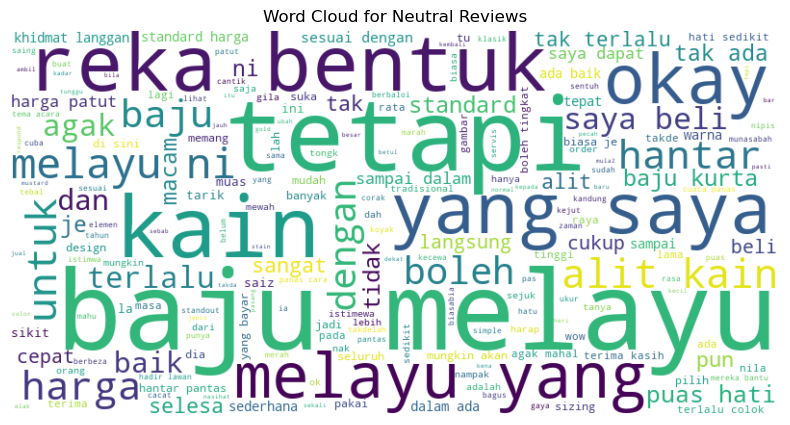

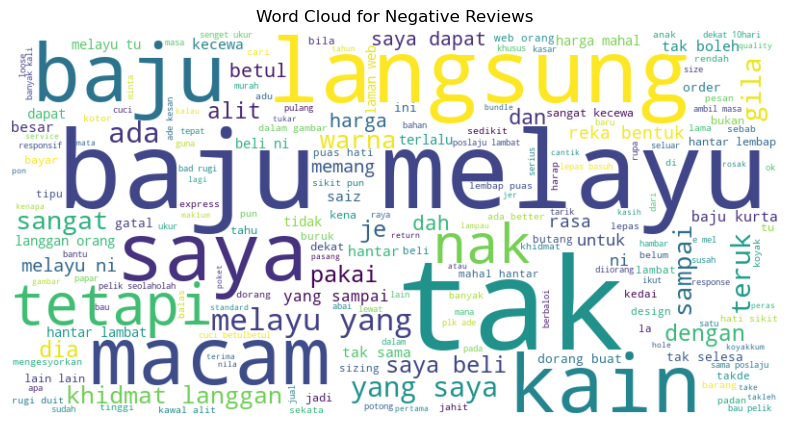

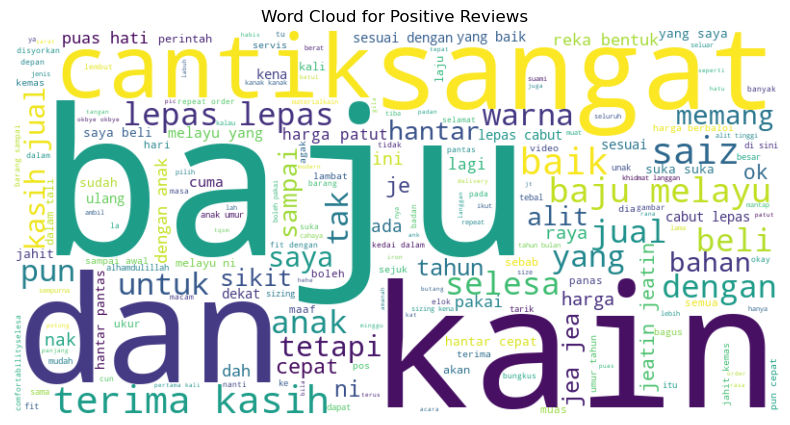

In [79]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Assuming you have a DataFrame named 'data' with columns 'Translated_Review_MS' and 'Sentiment_MS'
# If your DataFrame or column names are different, adjust accordingly

# Function to generate and display word cloud for a specific sentiment category
def generate_word_cloud(sentiment_category):
    # Filter the DataFrame for the specified sentiment category
    filtered_data = data[data['Sentiment_MS'] == sentiment_category]

    # Concatenate all reviews in the filtered DataFrame
    text = ' '.join(filtered_data['Translated_Review_MS'])

    # Generate WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

    # Display the WordCloud
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment_category} Reviews')
    plt.show()

# Generate word clouds for each sentiment category
sentiment_categories = data['Sentiment_MS'].unique()
for category in sentiment_categories:
    generate_word_cloud(category)


### 2.8 Save as .csv file

In [80]:
# Assuming 'data' is your DataFrame with columns 'Translated_Review_MS' and 'Sentiment_MS'
# If you have a different DataFrame or column names, adjust accordingly

# Create a DataFrame with only the desired columns
selected_columns = ['Translated_Review_MS', 'Sentiment_MS']
selected_data = data[selected_columns]

# Save the selected columns to a CSV file
selected_data.to_csv('Translated_Review_MS_with_sentiment_MS.csv', index=False)

# Display a message indicating that the CSV file has been created
print("Selected columns saved to Translated_Review_MS_with_sentiment_MS.csv")


Selected columns saved to Translated_Review_MS_with_sentiment_MS.csv


In [81]:
data_final = pd.read_csv('Translated_Review_MS_with_sentiment_MS.csv', encoding='latin1')
data_final.head()

,Translated_Review_MS,Sentiment_MS
0,baju kurta sampai dalam ada baik tetapi tak ad...,Neutral
1,sizing tak tepat langsung saya rasa macam baju...,Negative
2,baju kurta saya dah koyakkum pakai memang tak ...,Negative
3,hantar laju kain cantik terima kasih jual masi...,Positive
4,baju selamat darat kain cantik dan sedap di pa...,Positive


# 3.0 Feature Extration

In [84]:
data_final = pd.read_csv('Translated_Review_MS_with_sentiment_MS.csv')


data_final.isnull().any().any()

False

In [85]:
data_final.columns

Index(['Translated_Review_MS', 'Sentiment_MS'], dtype='object')

### 3.1 TF-IDF

In [116]:
# PROCESS TF-IDF (Feature Extraction) - Count Vector
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(data_final['Translated_Review_MS'].astype('U'))

tf = TfidfVectorizer()
text_tf = tf.fit_transform(data_final['Translated_Review_MS'].astype('U'))
print((text_tf))

  (0, 969)	0.5077560504139026
  (0, 1109)	0.19139080371648412
  (0, 993)	0.18432436109559552
  (0, 1040)	0.2184385611744318
  (0, 96)	0.26578536595009156
  (0, 34)	0.5152606698001073
  (0, 265)	0.2980912885325219
  (0, 852)	0.2421859084080995
  (0, 520)	0.3533307346575875
  (0, 100)	0.12398395557245183
  (1, 814)	0.4014754161475596
  (1, 1111)	0.41516753487529884
  (1, 886)	0.4319253338522811
  (1, 576)	0.24075914917906663
  (1, 806)	0.3189710203058939
  (1, 869)	0.15078537331605946
  (1, 541)	0.23930087544722622
  (1, 1022)	0.33784441657633535
  (1, 954)	0.3005626331834876
  (1, 993)	0.15679647960556065
  (1, 100)	0.10546759877957994
  (2, 58)	0.25513087320217737
  (2, 623)	0.31478734641225087
  (2, 711)	0.3104803861466498
  (2, 512)	0.5591190583038244
  :	:
  (459, 685)	0.2946619147296628
  (459, 637)	0.26296953455570055
  (459, 530)	0.2167166728599462
  (459, 502)	0.2761230607692962
  (459, 457)	0.18938210663592636
  (459, 1070)	0.17917943906407663
  (459, 200)	0.46255430876347653
 

### 4.0 Splitting Data

In [131]:
# Splitting the Translated_Review_MS_with_sentiment_MS.csv into train_data and test_data
# Where 80% for training purpose and 20% for testing purpose
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_final['Translated_Review_MS'], finalData['Sentiment_Rating'], test_size=0.2, random_state=42)

# Display the number of samples 
print("Number of samples in X_train:", len(x_train))
print("Number of samples in X_test:", len(x_test))
print("Number of samples in y_train:", len(y_train))
print("Number of samples in y_test:", len(y_test))

Number of samples in X_train: 369
Number of samples in X_test: 93
Number of samples in y_train: 369
Number of samples in y_test: 93


In [132]:
data_final.head()

,Translated_Review_MS,Sentiment_MS
0,baju kurta sampai dalam ada baik tetapi tak ad...,Neutral
1,sizing tak tepat langsung saya rasa macam baju...,Negative
2,baju kurta saya dah koyakkum pakai memang tak ...,Negative
3,hantar laju kain cantik terima kasih jual masi...,Positive
4,baju selamat darat kain cantik dan sedap di pa...,Positive


In [133]:
# pip install imbalanced-learn

In [134]:
# pip install tensorflow

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE
import pandas as pd
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

# Tokenize the text data
tokenizer = Tokenizer(num_words=1000) 
tokenizer.fit_on_texts(x_train)

# Convert text to sequences
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_test_sequences = tokenizer.texts_to_sequences(x_test)

# Pad sequences to have the same length
maxlen = 50
x_train_padded = pad_sequences(x_train_sequences, maxlen=maxlen, padding='post')
x_test_padded = pad_sequences(x_test_sequences, maxlen=maxlen, padding='post')

# Encode labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert labels to one-hot encoding
num_classes = len(label_encoder.classes_)
y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

# Assuming 'your_data.csv' is your dataset
data = pd.read_csv('Translated_Review_MS_with_sentiment_MS.csv')

# Assuming 'Review' column contains text data
text_data = data['Translated_Review_MS']

# Convert text data to numerical representation using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
text_matrix = tfidf_vectorizer.fit_transform(text_data)

# Assuming 'Rating' is your target variable
y = data['Sentiment_MS']

# Handling class imbalance with SMOTE
smote = SMOTE(random_state=42)
x_resampled, y_resampled = smote.fit_resample(x_train_padded, y_train_encoded)


# 5.0 Model Training, Testing and Evaluation 

### 5.1 Support Vector Machinem (SVM) - RBF 

In [138]:

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assuming x_train, x_test, y_train, y_test are already defined and contain your data
# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(data_final['Translated_Review_MS'], finalData['Sentiment_Rating'], test_size=0.2, random_state=42)

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=1000)  # You can adjust max_features based on your dataset size

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the same vectorizer
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Create an SVM model with RBF kernel
svm_rbf = SVC(kernel='rbf')

# Train the model
svm_rbf.fit(x_train_tfidf, y_train)

# Make predictions on the test set
predicted = svm_rbf.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, predicted)
print('The resulting accuracy using RBF is {:.2f}%'.format(100 * accuracy))


The resulting accuracy using RBF is 84.95%


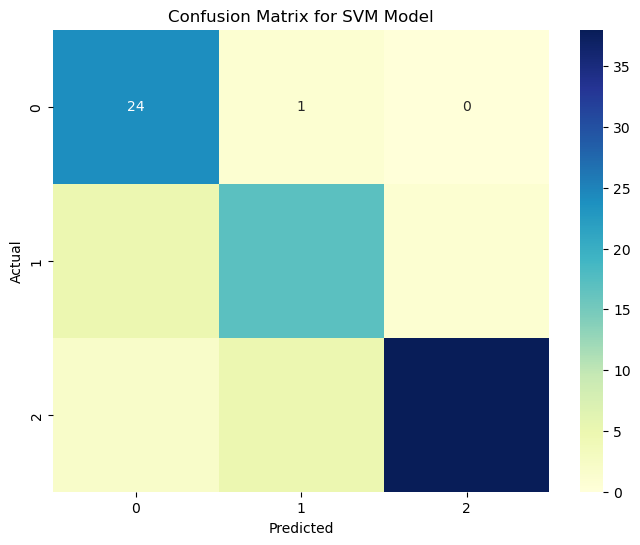

SVM Model Metrics:
Accuracy: 0.8495
Precision: 0.8495
Recall: 0.8495
F1 Score: 0.8495


In [139]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the confusion matrix for SVM
cm_svm = confusion_matrix(y_test, predicted)

# Plot the confusion matrix for SVM
plt.figure(figsize=(8, 6))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for SVM Model')
plt.show()

# Calculate performance metrics for SVM
accuracy_svm = accuracy_score(y_test, predicted)
precision_svm = precision_score(y_test, predicted, average='micro')
recall_svm = recall_score(y_test, predicted, average='micro')
f1_svm = f1_score(y_test, predicted, average='micro')

print('SVM Model Metrics:')
print('Accuracy: {:.4f}'.format(accuracy_svm))
print('Precision: {:.4f}'.format(precision_svm))
print('Recall: {:.4f}'.format(recall_svm))
print('F1 Score: {:.4f}'.format(f1_svm))


### 5.2 Simple Neural Network (SNN)

In [140]:
# from sklearn.preprocessing import LabelEncoder
# from keras.preprocessing.text import Tokenizer
# # from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Embedding, Flatten, Dense
# from keras.models import Sequential
# from keras.optimizers import Adam
# from keras.utils import to_categorical
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Tokenize the text data
# tokenizer = Tokenizer(num_words=10000)  # Adjust the vocabulary size as needed
# tokenizer.fit_on_texts(x_train)

# # Convert text to sequences
# x_train_sequences = tokenizer.texts_to_sequences(x_train)
# x_test_sequences = tokenizer.texts_to_sequences(x_test)

# # Pad sequences to have the same length
# maxlen = 50  # Adjust the sequence length as needed
# x_train_padded = pad_sequences(x_train_sequences, maxlen=maxlen, padding='post')
# x_test_padded = pad_sequences(x_test_sequences, maxlen=maxlen, padding='post')

# # Encode labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# # Convert labels to one-hot encoding
# num_classes = len(label_encoder.classes_)
# y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
# y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

# # Build a Simple Neural Network (SNN) model
# snn_model = Sequential()
# snn_model.add(Embedding(input_dim=10000, output_dim=100, input_length=maxlen))
# snn_model.add(Flatten())
# snn_model.add(Dense(128, activation='relu'))
# snn_model.add(Dense(num_classes, activation='softmax'))

# # Compile the model
# snn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the SNN model
# snn_model.fit(x_train_padded, y_train_one_hot, epochs=10, batch_size=128, validation_split=0.2)

# # Evaluate the SNN model on the test set
# score = snn_model.evaluate(x_test_padded, y_test_one_hot, verbose=1)
# print(f"SNN Model Test Loss: {score[0]}, Accuracy: {score[1]}")

# # Predictions on the test set
# y_pred_prob_snn = snn_model.predict(x_test_padded)
# y_pred_snn = np.argmax(y_pred_prob_snn, axis=1)

# # Decode the encoded labels
# y_test_labels = label_encoder.inverse_transform(y_test_encoded)
# y_pred_labels_snn = label_encoder.inverse_transform(y_pred_snn)

# # Calculate accuracy
# accuracy_snn = accuracy_score(y_test_labels, y_pred_labels_snn)
# print(f"SNN Model Accuracy on the test set: {accuracy_snn * 100:.2f}%")

In [141]:
# # Calculate the confusion matrix for SNN
# cm_snn = confusion_matrix(y_test_labels, y_pred_labels_snn)

# # Plot the confusion matrix for SNN
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_snn, annot=True, fmt='d', cmap="YlGnBu")
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for SNN Model')
# plt.show()

# # Calculate performance metrics for SNN
# precision_snn = precision_score(y_test_labels, y_pred_labels_snn, average='micro')
# recall_snn = recall_score(y_test_labels, y_pred_labels_snn, average='micro')
# f1_snn = f1_score(y_test_labels, y_pred_labels_snn, average='micro')

# print('SNN Model Metrics:')
# print('Precision: {:.4f}'.format(precision_snn))
# print('Recall: {:.4f}'.format(recall_snn))
# print('F1 Score: {:.4f}'.format(f1_snn))

### 5.3 Convolutional Neural Network (CNN)

In [142]:
# from sklearn.preprocessing import LabelEncoder
# from keras.preprocessing.text import Tokenizer
# # from keras.preprocessing.sequence import pad_sequences
# from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense
# from keras.models import Sequential
# from keras.optimizers import Adam
# from keras.utils import to_categorical
# from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
# import matplotlib.pyplot as plt
# import seaborn as sns
# import numpy as np

# # Tokenize the text data
# tokenizer = Tokenizer(num_words=10000)
# tokenizer.fit_on_texts(x_train)

# # Convert text to sequences
# x_train_sequences = tokenizer.texts_to_sequences(x_train)
# x_test_sequences = tokenizer.texts_to_sequences(x_test)

# # Pad sequences to have the same length
# maxlen = 50
# x_train_padded = pad_sequences(x_train_sequences, maxlen=maxlen, padding='post')
# x_test_padded = pad_sequences(x_test_sequences, maxlen=maxlen, padding='post')

# # Encode labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# # Convert labels to one-hot encoding
# num_classes = len(label_encoder.classes_)
# y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
# y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

# # Build a Convolutional Neural Network (CNN) model
# cnn_model = Sequential()
# cnn_model.add(Embedding(input_dim=10000, output_dim=100, input_length=maxlen))
# cnn_model.add(Conv1D(128, 5, activation='relu'))
# cnn_model.add(GlobalMaxPooling1D())
# cnn_model.add(Dense(128, activation='relu'))
# cnn_model.add(Dense(num_classes, activation='softmax'))

# # Compile the model
# cnn_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the CNN model
# cnn_model.fit(x_train_padded, y_train_one_hot, epochs=10, batch_size=128, validation_split=0.2)

# # Evaluate the CNN model on the test set
# score = cnn_model.evaluate(x_test_padded, y_test_one_hot, verbose=1)
# print(f"CNN Model Test Loss: {score[0]}, Accuracy: {score[1]}")

# # Make predictions on the test set
# y_pred_prob_cnn = cnn_model.predict(x_test_padded)
# y_pred_cnn = np.argmax(y_pred_prob_cnn, axis=1)

# # Decode the encoded labels
# y_test_labels = label_encoder.inverse_transform(y_test_encoded)
# y_pred_labels_cnn = label_encoder.inverse_transform(y_pred_cnn)

# # Calculate accuracy
# accuracy_cnn = accuracy_score(y_test_labels, y_pred_labels_cnn)
# print(f"CNN Model Accuracy on the test set: {accuracy_cnn * 100:.2f}%")

In [143]:
# # Calculate the confusion matrix for CNN
# cm_cnn = confusion_matrix(y_test_labels, y_pred_labels_cnn)

# # Plot the confusion matrix for CNN
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_cnn, annot=True, fmt='d', cmap="YlGnBu")
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for CNN Model')
# plt.show()

# # Calculate performance metrics for CNN
# precision_cnn = precision_score(y_test_labels, y_pred_labels_cnn, average='micro')
# recall_cnn = recall_score(y_test_labels, y_pred_labels_cnn, average='micro')
# f1_cnn = f1_score(y_test_labels, y_pred_labels_cnn, average='micro')

# print('CNN Model Metrics:')
# print('Precision: {:.4f}'.format(precision_cnn))
# print('Recall: {:.4f}'.format(recall_cnn))
# print('F1 Score: {:.4f}'.format(f1_cnn))

### 5.4 Long Short-Term Memory (LSTM)

In [144]:
# from keras.models import Sequential
# from keras.layers import Embedding, LSTM, Dense
# from sklearn.metrics import accuracy_score
# from sklearn.preprocessing import LabelEncoder
# from keras.preprocessing.text import Tokenizer
# # from keras.preprocessing.sequence import pad_sequences
# import numpy as np

# maxlen = 50  # Adjust the sequence length as needed

# # Tokenize the text data
# tokenizer = Tokenizer(num_words=10000) 
# tokenizer.fit_on_texts(x_train)

# # Convert text to sequences
# x_train_sequences = tokenizer.texts_to_sequences(x_train)
# x_test_sequences = tokenizer.texts_to_sequences(x_test)

# # Pad sequences to have the same length
# x_train_padded = pad_sequences(x_train_sequences, maxlen=maxlen, padding='post')
# x_test_padded = pad_sequences(x_test_sequences, maxlen=maxlen, padding='post')

# # Encode labels
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# # Convert labels to one-hot encoding
# num_classes = len(label_encoder.classes_)
# y_train_one_hot = to_categorical(y_train_encoded, num_classes=num_classes)
# y_test_one_hot = to_categorical(y_test_encoded, num_classes=num_classes)

# # Build an LSTM model
# lstm_model = Sequential()
# lstm_model.add(Embedding(input_dim=10000, output_dim=100, input_length=maxlen))
# lstm_model.add(LSTM(128))
# lstm_model.add(Dense(num_classes, activation='softmax'))

# # Compile the model
# lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# # Train the LSTM model
# lstm_model.fit(x_train_padded, y_train_one_hot, epochs=6, batch_size=128, validation_split=0.2)

# # Evaluate the LSTM model on the test set
# score = lstm_model.evaluate(x_test_padded, y_test_one_hot, verbose=1)
# print(f"LSTM Model Test Loss: {score[0]}, Accuracy: {score[1]}")

# # Predictions on the test set
# y_pred_prob_lstm = lstm_model.predict(x_test_padded)
# y_pred_lstm = np.argmax(y_pred_prob_lstm, axis=1)

# # Decode the encoded labels
# y_test_labels = label_encoder.inverse_transform(y_test_encoded)
# y_pred_labels_lstm = label_encoder.inverse_transform(y_pred_lstm)

# # Calculate accuracy
# accuracy_lstm = accuracy_score(y_test_labels, y_pred_labels_lstm)
# print(f"LSTM Model Accuracy on the test set: {accuracy_lstm * 100:.2f}%")


In [145]:
# # Calculate the confusion matrix for LSTM
# cm_lstm = confusion_matrix(y_test_labels, y_pred_labels_lstm)

# # Plot the confusion matrix for LSTM
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_lstm, annot=True, fmt='d', cmap="YlGnBu")
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for LSTM Model')
# plt.show()

# # Calculate performance metrics for LSTM
# precision_lstm = precision_score(y_test_labels, y_pred_labels_lstm, average='micro')
# recall_lstm = recall_score(y_test_labels, y_pred_labels_lstm, average='micro')
# f1_lstm = f1_score(y_test_labels, y_pred_labels_lstm, average='micro')

# print('LSTM Model Metrics:')
# print('Precision: {:.4f}'.format(precision_lstm))
# print('Recall: {:.4f}'.format(recall_lstm))
# print('F1 Score: {:.4f}'.format(f1_lstm))

### 5.5 Logistic Regression Model

In [146]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features based on your dataset size

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the same vectorizer
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Create a Logistic Regression model
logistic_regression_model = LogisticRegression()

# Train the model
logistic_regression_model.fit(x_train_tfidf, y_train)

# Make predictions on the test set
y_pred = logistic_regression_model.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: {:.2f}%'.format(100 * accuracy))

Accuracy: 84.95%


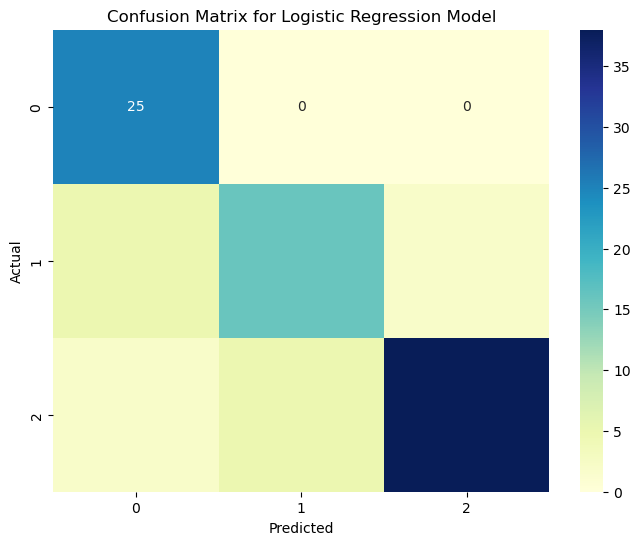

Logistic Regression Model Metrics:
Precision: 0.8495
Recall: 0.8495
F1 Score: 0.8495


In [147]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

cm_logistic_regression = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for Logistic Regression
plt.figure(figsize=(8, 6))
sns.heatmap(cm_logistic_regression, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Logistic Regression Model')
plt.show()

# Calculate performance metrics for Logistic Regression
precision_logistic_regression = precision_score(y_test, y_pred, average='micro')
recall_logistic_regression = recall_score(y_test, y_pred, average='micro')
f1_logistic_regression = f1_score(y_test, y_pred, average='micro')

print('Logistic Regression Model Metrics:')
print('Precision: {:.4f}'.format(precision_logistic_regression))
print('Recall: {:.4f}'.format(recall_logistic_regression))
print('F1 Score: {:.4f}'.format(f1_logistic_regression))


### 5.6 Naive Bayes 

In [148]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'X_train', 'X_test', 'y_train', and 'y_test' are your preprocessed training and testing sets
# Replace 'labels' with your actual target variable name
# X_train and X_test should be pandas Series containing your text data
# y_train and y_test should be the corresponding target variable

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features based on your dataset size

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the same vectorizer
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Create a Multinomial Naive Bayes model
naive_bayes = MultinomialNB()

# Train the model
naive_bayes.fit(x_train_tfidf, y_train)

# Make predictions on the test set
y_pred = naive_bayes.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('The resulting accuracy for Naive Bayes is {:.2f}%'.format(100 * accuracy))

The resulting accuracy for Naive Bayes is 81.72%


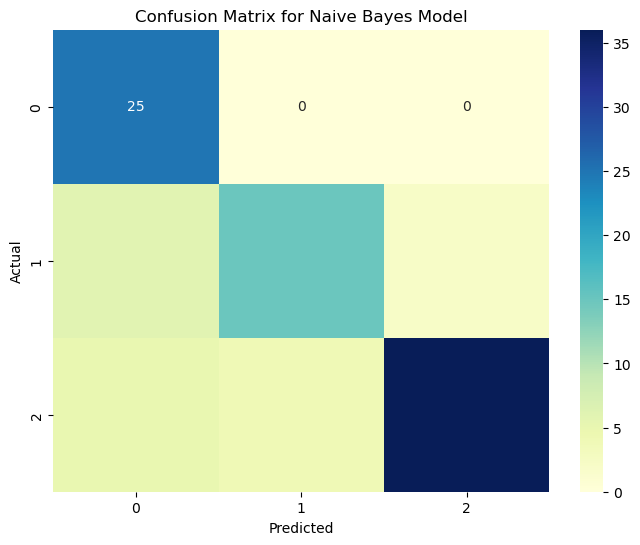

Naive Bayes Model Metrics:
Precision: 0.8172
Recall: 0.8172
F1 Score: 0.8172


In [149]:
# Calculate the confusion matrix for Naive Bayes
cm_naive_bayes = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for Naive Bayes
plt.figure(figsize=(8, 6))
sns.heatmap(cm_naive_bayes, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

# Calculate performance metrics for Naive Bayes
precision_naive_bayes = precision_score(y_test, y_pred, average='micro')
recall_naive_bayes = recall_score(y_test, y_pred, average='micro')
f1_naive_bayes = f1_score(y_test, y_pred, average='micro')

print('Naive Bayes Model Metrics:')
print('Precision: {:.4f}'.format(precision_naive_bayes))
print('Recall: {:.4f}'.format(recall_naive_bayes))
print('F1 Score: {:.4f}'.format(f1_naive_bayes))

### 5.7 Random Forest

In [150]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features based on your dataset size

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the same vectorizer
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Create a Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model
random_forest.fit(x_train_tfidf, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('The resulting accuracy for Random Forest Classifier is {:.2f}%'.format(100 * accuracy))

The resulting accuracy for Random Forest Classifier is 76.34%


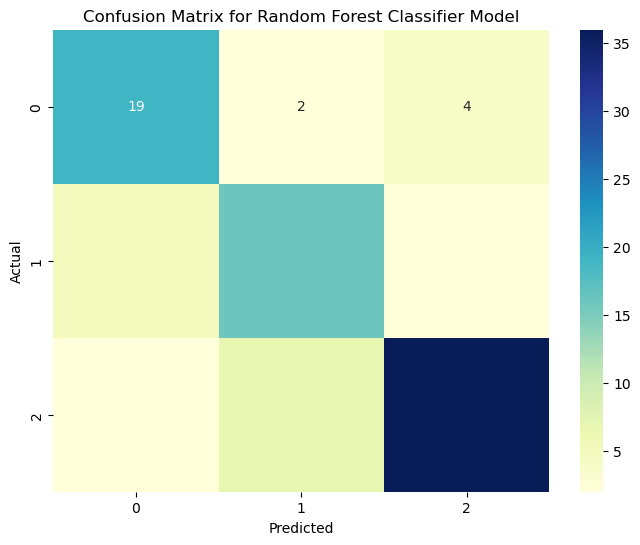

Random Forest Model Metrics:
Precision: 0.7634
Recall: 0.7634
F1 Score: 0.7634


In [151]:
# Calculate the confusion matrix for Random Forest
cm_random_forest = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for Random Forest
plt.figure(figsize=(8, 6))
sns.heatmap(cm_random_forest, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Random Forest Classifier Model')
plt.show()

# Calculate performance metrics for Random Forest
precision_random_forest = precision_score(y_test, y_pred, average='micro')
recall_random_forest = recall_score(y_test, y_pred, average='micro')
f1_random_forest = f1_score(y_test, y_pred, average='micro')

print('Random Forest Model Metrics:')
print('Precision: {:.4f}'.format(precision_random_forest))
print('Recall: {:.4f}'.format(recall_random_forest))
print('F1 Score: {:.4f}'.format(f1_random_forest))

### 5.8 K-Nearest Neighbours (KNN)

In [152]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features based on your dataset size

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the same vectorizer
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Create a KNN model
knn = KNeighborsClassifier(n_neighbors=5)

# Train the model
knn.fit(x_train_tfidf, y_train)

# Make predictions on the test set
y_pred = knn.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('The resulting accuracy for KNN is {:.2f}%'.format(100 * accuracy))

The resulting accuracy for KNN is 76.34%


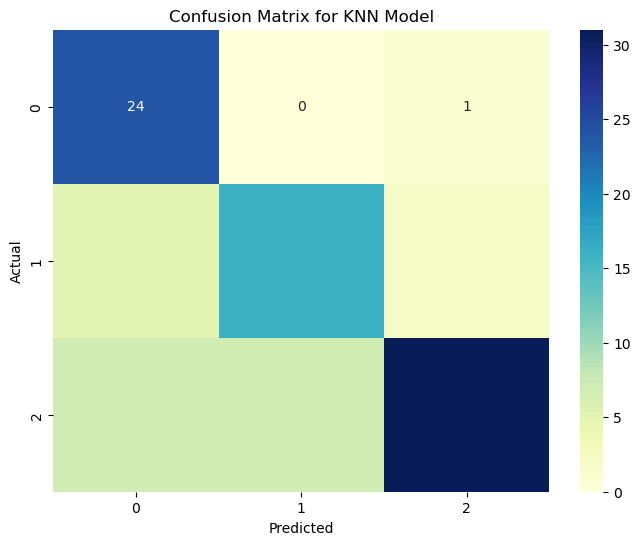

KNN Model Metrics:
Precision: 0.7634
Recall: 0.7634
F1 Score: 0.7634


In [153]:
# Calculate the confusion matrix for KNN
cm_knn = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix for KNN
plt.figure(figsize=(8, 6))
sns.heatmap(cm_knn, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for KNN Model')
plt.show()

# Calculate performance metrics for KNN
precision_knn = precision_score(y_test, y_pred, average='micro')
recall_knn = recall_score(y_test, y_pred, average='micro')
f1_knn = f1_score(y_test, y_pred, average='micro')

print('KNN Model Metrics:')
print('Precision: {:.4f}'.format(precision_knn))
print('Recall: {:.4f}'.format(recall_knn))
print('F1 Score: {:.4f}'.format(f1_knn))


### 5.9 Decision Tree

In [154]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Create a TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=10000)  # You can adjust max_features based on your dataset size

# Fit and transform the training data
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the same vectorizer
x_test_tfidf = tfidf_vectorizer.transform(x_test)

# Create a Decision Tree Classifier
dt_classifier = DecisionTreeClassifier()

# Train the model
dt_classifier.fit(x_train_tfidf, y_train)

# Make predictions on the test set
y_pred = dt_classifier.predict(x_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print('The resulting accuracy using Decision Tree Classifier is {:.2f}%'.format(100 * accuracy))

The resulting accuracy using Decision Tree Classifier is 70.97%


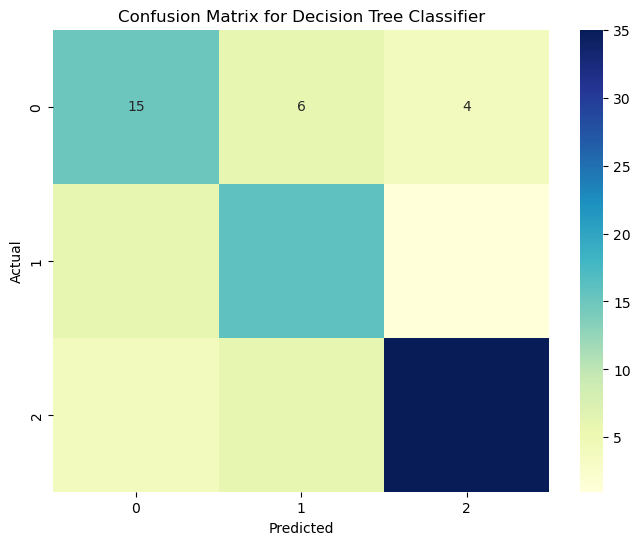

Decision Tree Classifier Metrics:
Precision: 0.7097
Recall: 0.7097
F1 Score: 0.7097


In [155]:
# Calculate the confusion matrix
cm_dt = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_dt, annot=True, fmt='d', cmap="YlGnBu")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for Decision Tree Classifier')
plt.show()

# Calculate performance metrics
precision_dt = precision_score(y_test, y_pred, average='micro')
recall_dt = recall_score(y_test, y_pred, average='micro')
f1_dt = f1_score(y_test, y_pred, average='micro')

print('Decision Tree Classifier Metrics:')
print('Precision: {:.4f}'.format(precision_dt))
print('Recall: {:.4f}'.format(recall_dt))
print('F1 Score: {:.4f}'.format(f1_dt))

### 5.10 VADER Sentiment

In [156]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from nltk.sentiment import SentimentIntensityAnalyzer
# from sklearn.metrics import accuracy_score

# # Initialize the VADER sentiment analyzer
# sid = SentimentIntensityAnalyzer()

# # Perform sentiment analysis on the training set
# train_sentiments = [sid.polarity_scores(text)['compound'] for text in x_train]

# # Perform sentiment analysis on the test set
# test_sentiments = [sid.polarity_scores(text)['compound'] for text in x_test]

# # Convert sentiment scores to labels (Positive, Negative, Neutral)
# train_pred_labels = ['Positive' if score >= 0.05 else 'Negative' if score <= -0.05 else 'Neutral' for score in train_sentiments]
# test_pred_labels = ['Positive' if score >= 0.05 else 'Negative' if score <= -0.05 else 'Neutral' for score in test_sentiments]

# # Calculate accuracy on the test set
# accuracy_test = accuracy_score(y_test, test_pred_labels)
# print('The resulting accuracy using VADER Sentiment is {:.2f}%'.format(100 * accuracy_test))

In [157]:
# from sklearn.metrics import classification_report

# # Calculate confusion matrix for the test set
# cm_test = confusion_matrix(y_test, test_pred_labels, labels=['Positive', 'Negative', 'Neutral'])

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm_test, annot=True, fmt='d', cmap="YlGnBu", xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for VADER Sentiment Analysis')
# plt.show()

# # Calculate classification report
# classification_rep = classification_report(y_test, test_pred_labels, labels=['Positive', 'Negative', 'Neutral'], digits=4)

# # Extract precision, recall, and F1 score from the classification report
# precision_vader, recall_vader, f1_vader, _ = map(float, classification_rep.split()[-4:])

# # Display precision, recall, and F1 score
# print('VADER Model Metrics:')
# print('Precision: {:.4f}'.format(precision_vader))
# print('Recall: {:.4f}'.format(recall_vader))
# print('F1 Score: {:.4f}'.format(f1_vader))

### 5.11 BERT Model

In [158]:
# import torch
# from torch.utils.data import TensorDataset, DataLoader
# from transformers import BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
# from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# import seaborn as sns
# import matplotlib.pyplot as plt
# import pandas as pd

# # Encode labels to numerical format
# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# y_test_encoded = label_encoder.transform(y_test)

# # Convert labels to Long type
# y_train = torch.tensor(y_train_encoded, dtype=torch.long)
# y_test = torch.tensor(y_test_encoded, dtype=torch.long)

# # Define the BERT model and tokenizer
# model_name = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(model_name)
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=3)  # Assuming 3 classes

# # Tokenize and encode the training set
# train_encodings = tokenizer(list(x_train), truncation=True, padding=True, return_tensors='pt')
# y_train = torch.tensor(y_train_encoded, dtype=torch.long)

# # Tokenize and encode the test set
# test_encodings = tokenizer(list(x_test), truncation=True, padding=True, return_tensors='pt')
# y_test = torch.tensor(y_test_encoded, dtype=torch.long)

# # Create DataLoader for efficient batch processing
# train_dataset = TensorDataset(train_encodings['input_ids'], train_encodings['attention_mask'], y_train)
# train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# test_dataset = TensorDataset(test_encodings['input_ids'], test_encodings['attention_mask'], y_test)
# test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

# # Define optimizer and scheduler
# optimizer = AdamW(model.parameters(), lr=5e-5)
# total_steps = len(train_loader) * 2  # 2 epochs
# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# # Training loop
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# model.to(device)

# for epoch in range(2):  # Change the number of epochs as needed
#     model.train()
#     for batch in train_loader:
#         inputs = {'input_ids': batch[0].to(device),
#                   'attention_mask': batch[1].to(device),
#                   'labels': batch[2].to(device)}
        
#         optimizer.zero_grad()
#         outputs = model(**inputs)
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         scheduler.step()

# # Evaluation
# model.eval()
# predictions = []
# true_labels = []

# with torch.no_grad():
#     for batch in test_loader:
#         inputs = {'input_ids': batch[0].to(device),
#                   'attention_mask': batch[1].to(device),
#                   'labels': batch[2].to(device)}
        
#         outputs = model(**inputs)
#         logits = outputs.logits
#         preds = torch.argmax(logits, dim=1)
        
#         predictions.extend(preds.cpu().numpy())
#         true_labels.extend(batch[2].cpu().numpy())

# # Calculate accuracy
# accuracy = accuracy_score(true_labels, predictions)
# print(f"Accuracy: {accuracy * 100:.2f}%")

In [159]:
# # Calculate confusion matrix
# cm = confusion_matrix(true_labels, predictions)

# # Plot the confusion matrix
# plt.figure(figsize=(8, 6))
# sns.heatmap(cm, annot=True, fmt='d', cmap="YlGnBu", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
# plt.xlabel('Predicted')
# plt.ylabel('Actual')
# plt.title('Confusion Matrix for BERT Model')
# plt.show()

# # Calculate performance metrics for BERT
# precision_bert = precision_score(true_labels, predictions, average='micro')
# recall_bert = recall_score(true_labels, predictions, average='micro')
# f1_bert = f1_score(true_labels, predictions, average='micro')

# print('BERT Model Metrics:')
# print('Precision: {:.4f}'.format(precision_bert))
# print('Recall: {:.4f}'.format(recall_bert))
# print('F1 Score: {:.4f}'.format(f1_bert))

# 6.0 Sentiment Analysis

#### After model training, testing and evaluation,  an appropriate sentiment analysis model that can effectively handle the OOV nature of Malaysia Rojak language is Logistic Regression Model with the highest accuracy of 77.78%

In [171]:

import joblib
# Save the trained model to a .pkl file
joblib.dump(logistic_regression_model, 'logistic_regression_model.pkl')


['logistic_regression_model.pkl']

In [172]:
def analyze_sentiment():
    review = text_area.get("1.0", "end-1c")

    if review:
        # Translate the review to Malay
        translation = translator.translate(review, dest='ms')
        translated_review = translation.text

        # Vectorize the translated review
        review_vectorized = tfidf_vectorizer.transform([translated_review])

        # Predict sentiment and get probability estimates
        sentiment = rf_classifier_tfidf.predict(review_vectorized)[0]
        confidence = rf_classifier_tfidf.predict_proba(review_vectorized)
        confidence_level = max(confidence[0]) * 100

        # Display the result with color-coded sentiment and confidence level
        if sentiment == 'Positive':
            result_label.config(text=f"It is a {sentiment} review with {confidence_level:.2f}% confidence.", foreground="#4CAF50", font=('Helvetica', 14, 'bold'))
#         elif sentiment == 'Neutral':
            result_label.config(text=f"It is a {sentiment} review with {confidence_level:.2f}% confidence.", foreground="#808080", font=('Helvetica', 14, 'bold'))
        else:
            result_label.config(text=f"It is a {sentiment} review with {confidence_level:.2f}% confidence.", foreground="#FF0000", font=('Helvetica', 14, 'bold'))
    else:
        result_label.config(text="Please enter a review.", foreground="#FF0000", font=('Helvetica', 12, 'italic'))


In [173]:
from tkinter import *
from tkinter import ttk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from googletrans import Translator
import joblib
import tkinter as tk


# Load the pre-trained Logistic Regression model
logistic_regression_model = joblib.load('logistic_regression_model.pkl')  # Provide the correct path

# Initialize the translator object
translator = Translator()

# Assuming 'x_train' is your training data
tfidf_vectorizer = TfidfVectorizer(max_features=10000)
x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)

# Function to perform sentiment analysis
def analyze_sentiment():
    review = text_area.get("1.0", "end-1c")

    if review:
        # Translate the review to Malay
        translation = translator.translate(review, dest='ms')
        translated_review = translation.text

        # Vectorize the translated review
        review_vectorized = tfidf_vectorizer.transform([translated_review])

        # Predict sentiment
        sentiment = logistic_regression_model.predict(review_vectorized)[0]

        # Display the result with color-coded sentiment
        if sentiment == 'Positive':
            result_label.config(text=f"It is a {sentiment} review.", foreground="#4CAF50", font=('Helvetica', 14, 'bold'))
        elif sentiment == 'Neutral':
            result_label.config(text=f"It is a {sentiment} review.", foreground="#808080", font=('Helvetica', 14, 'bold'))
        else:
            result_label.config(text=f"It is a {sentiment} review.", foreground="#FF0000", font=('Helvetica', 14, 'bold'))
    else:
        result_label.config(text="Please enter a review.", foreground="#FF0000", font=('Helvetica', 12, 'italic'))

# Create the main application window
app = tk.Tk()
app.title("Sentiment Analysis")
app.geometry("700x400")  # Set the increased size of the window

# Set the background color to light blue
app.configure(bg='#d8e2eb')

# Create and place widgets with some styling
label = ttk.Label(app, text="Enter Review:", font=('Helvetica', 11, 'bold'), background='#d8e2eb')
label.grid(row=0, column=0, padx=(52, 10), pady=(55,0))

text_area = tk.Text(app, height=5, width=60, font=('Helvetica', 11))
text_area.grid(row=0, column=1, padx=5, pady=(55,0))

analyze_button = ttk.Button(app, text="Analyze", command=analyze_sentiment, style='TButton')
analyze_button.grid(row=1, column=0, columnspan=2, padx=(72, 10),pady=(20,10))

result_label = ttk.Label(app, text="", font=('Helvetica', 11), background='#d8e2eb')
result_label.grid(row=2, column=0, columnspan=2, padx=(73,10),pady=10)

# Add some styling to the button
style = ttk.Style()
style.configure('TButton', font=('Helvetica', 11, 'bold'))

# Run the application
app.mainloop()

In [ ]:
# Example of Reviews to be tested

# Positive Review: I like this baju melayu. Customer service sngt baik, dan delivery pun cepat. tq
# Neutral Review: baju ni okay jer dipakai, kualiti match dgn harga
# Negative Review 1: Kain baju ni teruk ... penghantaran lambat, tak kan repeat order lagi ...